In [13]:
from platform import python_version

python_version()

'3.11.6'

,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data/hora           50530 non-null  object 
 1   ActivePower(kW)     50530 non-null  float64
 2   WindSpeed(m/s)      50530 non-null  float64
 3   Curva_Teórica(KWh)  50530 non-null  float64
 4   Direção do Vento    50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None
Melhor solução encontrada: [0.933475901163727]


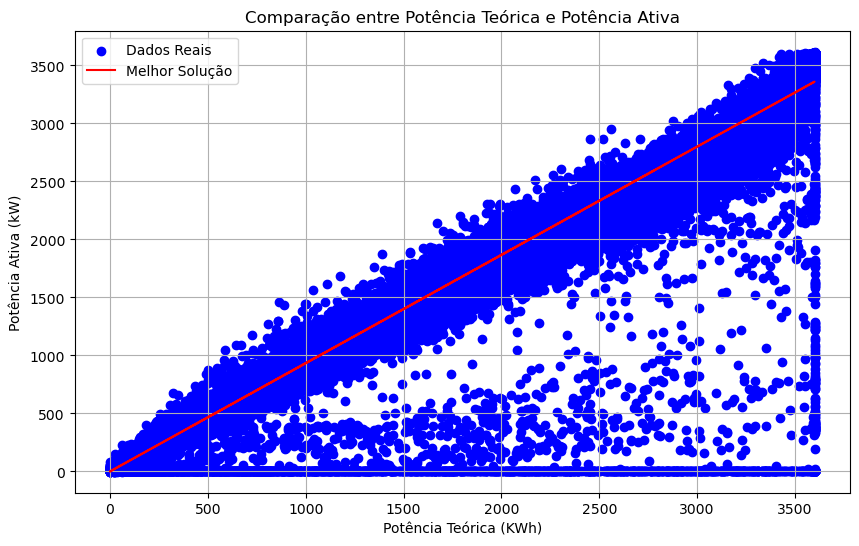

Melhor solução encontrada para a função Rastrigin: [2.489377514694289, -7.344797278705097, -5.014911045067329, -5.67921762057385, -15.012205312129867, -5.644042910028705, -19.893278993318027, 4.817377472256274, 344.8354705854047, -2806495.075543634]


In [14]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

# Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

print(turbina.info())

# Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual):
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(turbina['ActivePower(kW)'] - individual * turbina['Curva_Teórica(KWh)'])
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return -np.mean(diff),

# Definir a função de aptidão (fitness function) para a função Rastrigin
def fitness_function_rastrigin(individual):
    # Implementação da função Rastrigin
    A = 10
    n = len(individual)
    sum_term = sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in individual])
    return -A * n + sum_term,

# Definir o tamanho da população e o intervalo de valores para as variáveis de decisão
POP_SIZE = 100
VAR_LOWER = 0.0
VAR_UPPER = 2.0

# Criar tipos de indivíduo e de fitness para o algoritmo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Inicializar a população e as ferramentas do algoritmo genético
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, VAR_LOWER, VAR_UPPER)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function_turbina)  # Usar a função de aptidão para a Turbina
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Criar a população inicial
pop = toolbox.population(n=POP_SIZE)

# Executar o algoritmo evolutivo
NGEN = 50
for gen in range(NGEN):
    # Selecionar os indivíduos para reprodução
    offspring = toolbox.select(pop, len(pop))
    # Clonar os indivíduos selecionados
    offspring = [toolbox.clone(ind) for ind in offspring]

    # Aplicar crossover e mutação
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)  # Corrigir este trecho
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Avaliar a aptidão dos novos indivíduos
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Substituir a população pela nova geração
    pop[:] = offspring

# Selecionar o melhor indivíduo da população final
best_ind = tools.selBest(pop, 1)[0]

print("Melhor solução encontrada:", best_ind)

# Plotar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(turbina['Curva_Teórica(KWh)'], turbina['ActivePower(kW)'], label='Dados Reais', color='blue')
plt.plot(turbina['Curva_Teórica(KWh)'], best_ind[0] * turbina['Curva_Teórica(KWh)'], label='Melhor Solução', color='red')
plt.xlabel('Potência Teórica (KWh)')
plt.ylabel('Potência Ativa (kW)')
plt.title('Comparação entre Potência Teórica e Potência Ativa')
plt.legend()
plt.grid(True)
plt.show()

# Definir o tamanho da população e o intervalo de valores para as variáveis de decisão para a função Rastrigin
POP_SIZE_RASTRIGIN = 100
VAR_LOWER_RASTRIGIN = -5.12
VAR_UPPER_RASTRIGIN = 5.12

# Inicializar a população e as ferramentas do algoritmo genético para a função Rastrigin
toolbox_rastrigin = base.Toolbox()
toolbox_rastrigin.register("attr_float", random.uniform, VAR_LOWER_RASTRIGIN, VAR_UPPER_RASTRIGIN)
toolbox_rastrigin.register("individual", tools.initRepeat, creator.Individual, toolbox_rastrigin.attr_float, n=10)  # 10 variáveis para a função Rastrigin
toolbox_rastrigin.register("population", tools.initRepeat, list, toolbox_rastrigin.individual)
toolbox_rastrigin.register("evaluate", fitness_function_rastrigin)  # Usar a função de aptidão para a função Rastrigin
toolbox_rastrigin.register("mate", tools.cxBlend, alpha=0.5)
toolbox_rastrigin.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox_rastrigin.register("select", tools.selTournament, tournsize=3)

# Criar a população inicial para a função Rastrigin
pop_rastrigin = toolbox_rastrigin.population(n=POP_SIZE_RASTRIGIN)

# Executar o algoritmo evolutivo para a função Rastrigin
for gen in range(NGEN):
    # Selecionar os indivíduos para reprodução
    offspring = toolbox_rastrigin.select(pop_rastrigin, len(pop_rastrigin))
    # Clonar os indivíduos selecionados
    offspring = [toolbox_rastrigin.clone(ind) for ind in offspring]

    # Aplicar crossover e mutação
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_rastrigin.mate(child1, child2)  # Corrigir este trecho
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_rastrigin.mutate(mutant)
            del mutant.fitness.values

    # Avaliar a aptidão dos novos indivíduos
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_rastrigin.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Substituir a população pela nova geração
    pop_rastrigin[:] = offspring

# Selecionar o melhor indivíduo da população final para a função Rastrigin
best_ind_rastrigin = tools.selBest(pop_rastrigin, 1)[0]

print("Melhor solução encontrada para a função Rastrigin:", best_ind_rastrigin)


(50530, 1) (50530, 1)
Mean Squared Error: 292677.2876232669


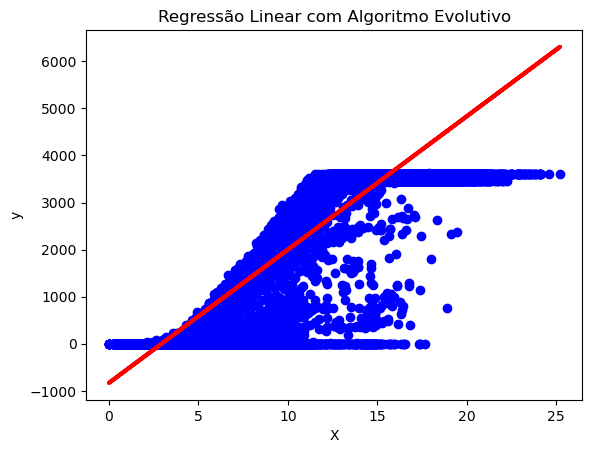

In [29]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from deap import base, creator, tools, algorithms
import random

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Selecionar características e separar em X e y
X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values

print(X.shape,y.shape)

# Divisão do conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação e ajuste do modelo de regressão linear
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Avaliação do desempenho do modelo nos dados de teste
y_pred = regression_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Plotar os dados e a linha de regressão
import matplotlib.pyplot as plt

plt.scatter(X, y, color='blue')
plt.plot(X, regression_model.predict(X), color='red', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regressão Linear com Algoritmo Evolutivo')
plt.show()


In [18]:
!xhost +

access control disabled, clients can connect from any host


In [17]:
import tkinter as Tkinter
import pyautogui
import mouseinfo


pyautogui.position()

Point(x=423, y=423)